**Aufgabe 44:**

Wenden Sie verschiedene lineare Mehrschrittverfahren auf das Anfangswertproblem zur Wärmeleitungsgleichung aus Aufgabe 29 an. Verwenden Sie dazu:

**a)** Das Adams-Bashforth Verfahren mit $k = 3$.  <br>
**b)** Die Adams-Moulton Verfahren mit $k = 2, 3$. <br>
**c)** Das BDF Verfahren

\begin{align}
                    y_{\ell + 1}
    - \frac{48}{25} y_{\ell}
    + \frac{36}{25} y_{\ell - 1}
    - \frac{16}{25} y_{\ell - 2}
    + \frac{3}{25}  y_{\ell - 3}
    =
    h \frac{12}{25} f(t_{\ell + 1}, y_{\ell + 1})
\end{align}

Optimieren Sie jeweils die Schrittweite $h$, d.h. wählen Sie $h$ so groß wie möglich, wobei $\| U(t) \|_\infty$ aber noch in der Zeit fallen sollte. Was beobachten Sie?

*Hinweis:* Für die impliziten Verfahren benötigen Sie keine Netwon Iteration, sondern können die auftretenden Gleichungen explizit lösen. Beachten Sie dabei Aufgabe 29c.

In [1]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
# aus Aufgabe 31 ...

def RK4():
    
    """
        returns the butcher table of the 2-stage Gauss method
        consistency order ... 4
    """

    c = np.array([0, 1/2, 1/2, 1])
    A = np.array([[0,   0,   0, 0],
                  [1/2, 0,   0, 0],
                  [0,   1/2, 0, 0],
                  [0,   0,   1, 0]])
    b = np.array([1/6, 1/3, 1/3, 1/6])
    
    return c, A, b

# ---------------------------------------------------------------- #

def explicit_RK(f, y_0, t, butcher_tableau):
    
    """
        applies an explicit Runge-Kutta-Method
        returns approximation vector
        f ..... right hand side of ODE
                (should return numpy array)
        y_0 ... initial value of ODE
                (should be numpy array)
        t ..... time stamps, where to approximate
    """
    
    c, A, b = butcher_tableau
    m = len(c)
    
    # dimension of ODE
    n = len(y_0)
    
    # time steps
    h = t[1::] - t[:-1:]

    # number of time steps
    N = len(h)

    # potential approximation vector
    y = np.zeros((N+1, n))
    y[0] = y_0
#     print('y_0 =')
#     print(y_0)
#     print('')
    
    for ell in range(N):
        
        # increments
        k = np.zeros((m, n))
        
        for i in range(m):
            
            t_ = t[ell] + c[i] * h[ell]
            y_ = y[ell] + h[ell] * sum([A_ * k_ for A_, k_ in zip(A[i, :i-1:], k[:i-1:, :])])

            k[i] = f(t_, y_)
            
        Phi = sum([b_ * k_ for b_, k_ in zip(b, k)])
        y[ell+1] = y[ell] + h[ell] * Phi
#         print('y[{}+1] ='.format(ell))
#         print(y[ell+1])
#         print('')
    
    return y

# ---------------------------------------------------------------- #

def plot_ODE(t, y, title = 'Hier könnte Ihre Werbung stehen!'):

    """
        plots (approximation of) solution of ODE
        t ... time
        y ... solutions (as matrix)
    """

    fig = plt.figure()

    for i, y_ in enumerate(y):
        plt.plot(t, y_, label = '$y_{}$'.format(i+1))

    plt.xlabel('$t$')
    plt.ylabel('$y$')
    plt.legend()
    plt.suptitle(title)

    plt.grid(linestyle = ':')
    plt.show()

In [10]:
# ACHTUNG:
# In dem folgenden solver wird nicht mit Funktionsauswertungen gegeizt.
# Man könnte diese auch zwischenspeichern und somit mehr Effizient rausholen.
# So motiviert war ich dann doch wieder nicht!

def explicit_multistep_ODE_solver(alpha, beta, h, f, y_init, t_0, T):

    """
        This function approximates the solution of a given ODE with a given explicit multi-step method.
        alpha .... characterizes multi-step method, last coefficient must be 1
        beta ..... characterizes multi-step method, last coefficient must be 0
        h ........ uniform step size
        f ........ right hand side of ODE
        y_init ... initial values of ODE
        t_0 ...... lower bound of interval
        T ........ upper bound of interval
    """

    # k-step method
    # dimension ODE
    k, n = y_init.shape
    k -= 1
#     print('n =', n, '\n')


    # time nodes
    t = np.arange(t_0, T, h)

    # t_0, ..., t_N
    N = len(t) - 1

    y = np.zeros((N+1, n))
#     print('y (inital) =')
#     print(y)
#     print('y[:k+1] (initial) =')
#     print(y[:k+1])
    y[:k+1] = y_init

    for ell in range(k, N):
        y[ell+1] = sum([h * beta[k+1-j] * f(t[ell+1-j], y[ell+1-j]) - alpha[k+1-j] * y[ell+1-j] for j in range(1, k+2)])
#         print('y[{}+1] ='.format(ell))
#         print(y[ell+1])
#         print('')

    return y.transpose()

# -------------------------------- #

def implicit_multistep_ODE_solver_special(alpha, beta, tau, M, y_init, t_0, T):

    """
        This function approximates the solution of a given ODE with a given implicit multi-step method.
        The ODE must be linear and homogeneous, i.e. the right hand side given by a matrix.
        alpha .... characterizes multi-step method, last coefficient must be 1
        beta ..... characterizes multi-step method
        tau ...... uniform step size
        M ........ matrix for right hand side of ODE
        y_init ... initial values of ODE
        t_0 ...... lower bound of interval
        T ........ upper bound of interval
    """

    # k-step method
    # dimension ODE
    k, n = y_init.shape
#     print('y_init.shape =', y_init.shape)
    k -= 1

#     print('k =', k)
#     print('beta =')
#     print(beta)
#     print('')

    # time nodes
    t = np.arange(t_0, T, tau)

    # t_0, ..., t_N
    N = len(t) - 1

    y = np.zeros((N+1, n))
    y[:k+1] = y_init

    I = np.identity(n)
#     print('I - tau * M * beta[k] =')
#     print(I - tau * M * beta[k])
#     print('')
    LU = lu_factor(I - tau * M * beta[k])

    for ell in range(k, N):

        b = sum([(tau*beta[k-j]*M - alpha[k-j]*I) @ y[ell+1-j] for j in range(1, k+1)])
        y[ell+1] = lu_solve(LU, b)

    return y.transpose()

In [4]:
def adams_bashforth(k):

    """
        This function returns the k-th Adams-Bashforth method.
    """
    
    alpha = None
    beta  = None

    if k == 0:

        alpha = np.array([-1, 1])
        beta  = np.array([ 1, 0])

    if k == 1:

        alpha = np.array([ 0, -1, 1])
        beta  = np.array([-1,  3, 0]) / 2

    if k == 2:

        alpha = np.array([0,  0, -1,  1])
        beta  = np.array([5, -16, 23, 0]) / 12

    if k == 3:

        alpha = np.array([ 0, 0,   0, -1,  1])
        beta  = np.array([-9, 37, -59, 55, 0]) / 24

    return alpha, beta

# -------------------------------- #

def adams_moulton(k):

    """
        This function returns the k-th Adams-Bashforth method.
    """
    
    alpha = None
    beta  = None

    if k == 0:

        alpha = np.array([-1, 1])
        beta  = np.array([ 0, 1])

    if k == 1:

        alpha = np.array([-1, 1])
        beta  = np.array([ 1, 1]) / 2

    if k == 2:

        alpha = np.array([ 0, -1, 1])
        beta  = np.array([-1,  8, 5]) / 12

    if k == 3:

        alpha = np.array([0,  0, -1,  1])
        beta  = np.array([1, -5,  19, 9]) / 24

    return alpha, beta

# -------------------------------- #

def BDF():

    alpha = np.array([3, -16, 36, -48, 25]) / 25
    beta  = np.array([0,  0,  0,   0,  12]) / 25

    return alpha, beta

In [5]:
def M(h):

    N = int(1/h)
 
    a = np.ones(N-1) * (-2)
    b = np.ones(N-2)
    M = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)

    return M / h**2

g = lambda x: np.exp(-30 * (x - 1/2)**2)

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.5 



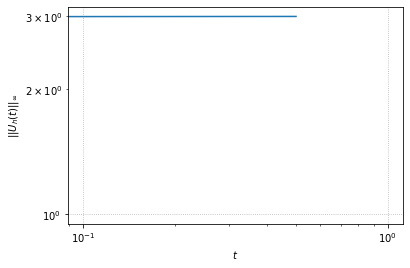

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.25 



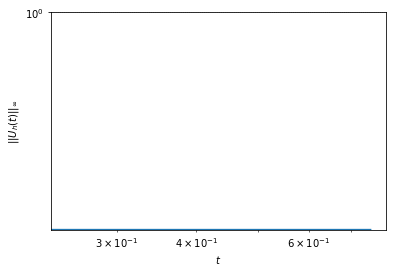

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.125 



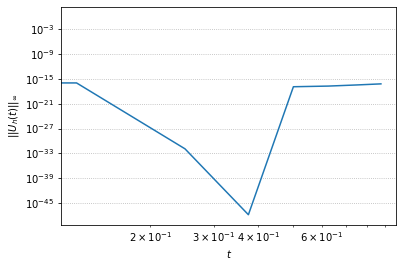

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.0625 



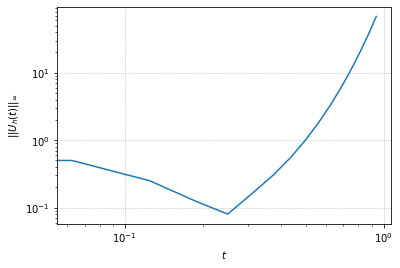

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.03125 



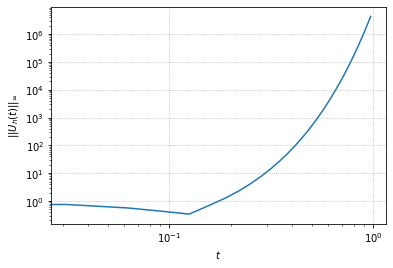

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.5 

tau = 0.015625 



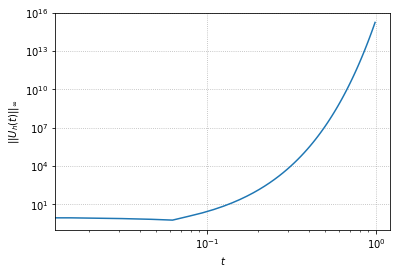

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.5 



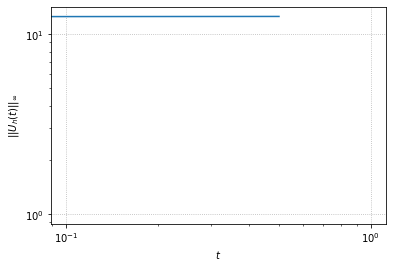

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.25 



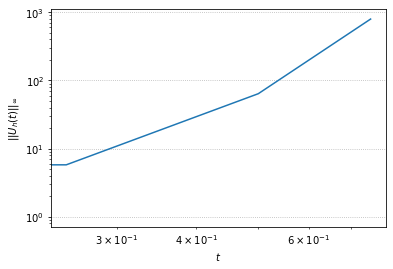

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.125 



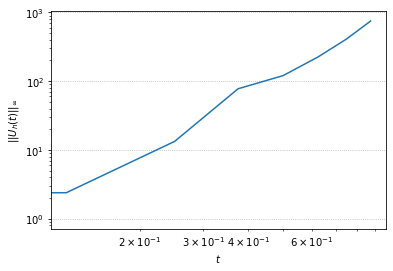

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.0625 



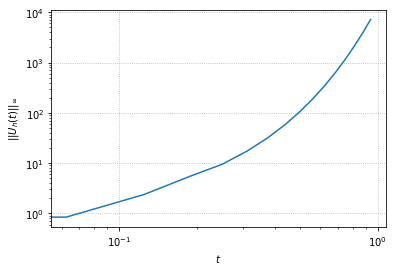

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.03125 



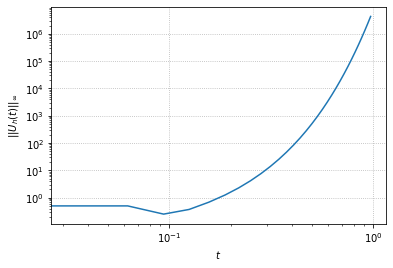

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.25 

tau = 0.015625 



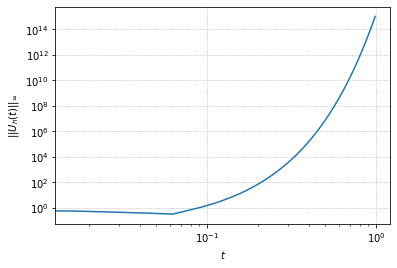

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.5 



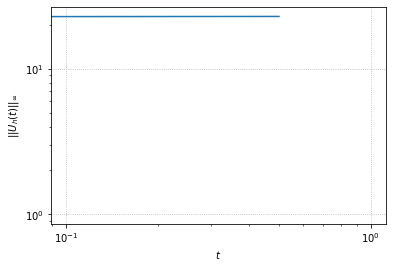

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.25 



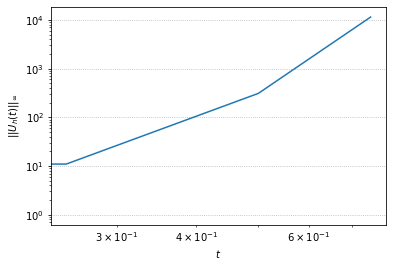

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.125 



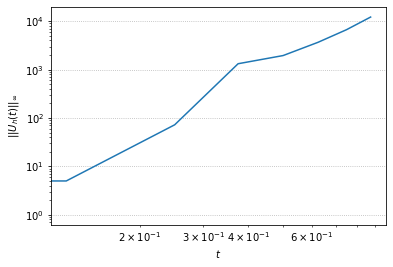

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.0625 



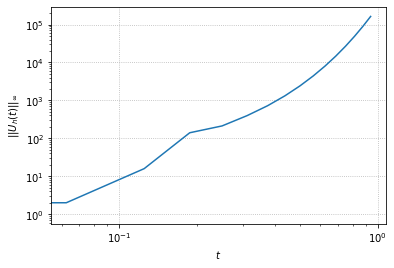

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.03125 



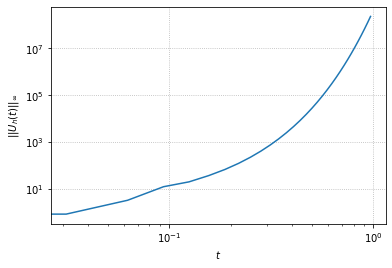

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.125 

tau = 0.015625 



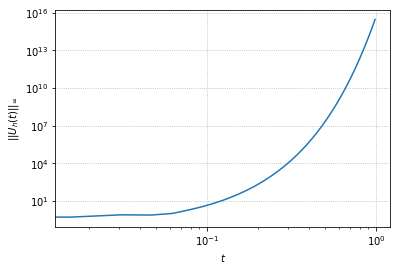

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.5 



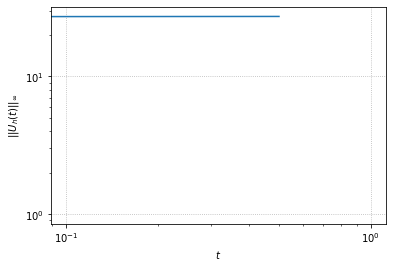

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.25 



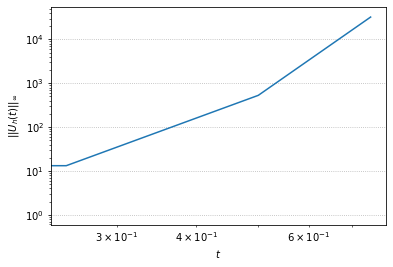

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.125 



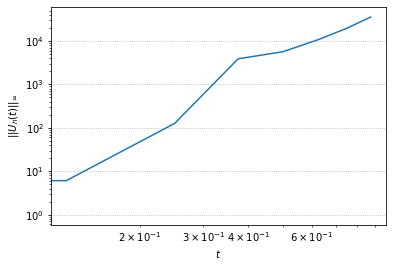

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.0625 



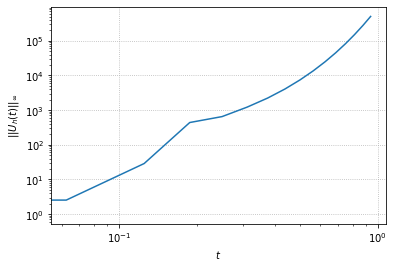

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.03125 



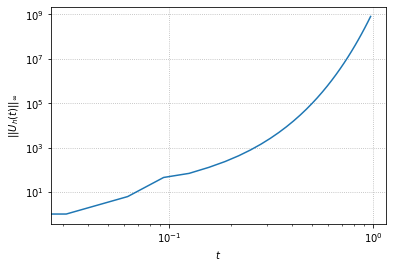

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.0625 

tau = 0.015625 



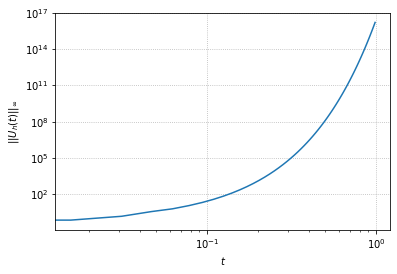

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.5 



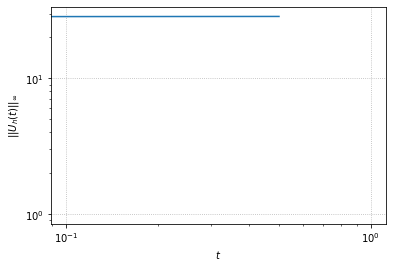

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.25 



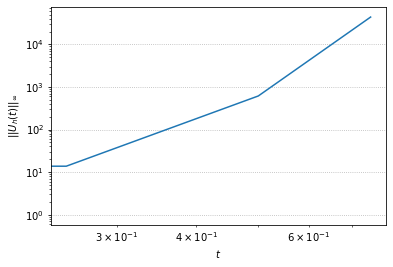

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.125 



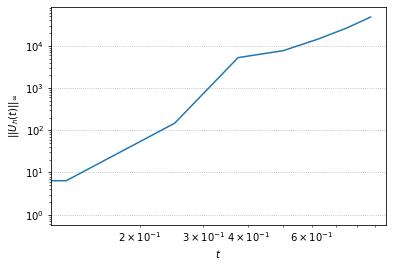

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.0625 



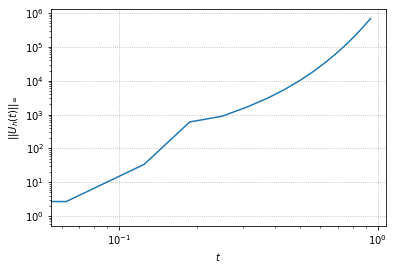

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.03125 



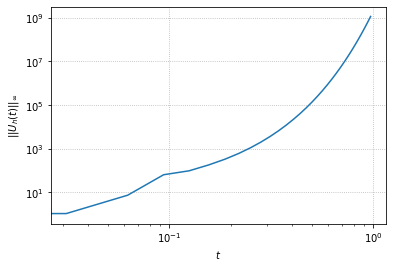

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.03125 

tau = 0.015625 



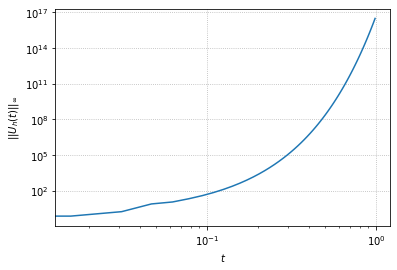

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.5 



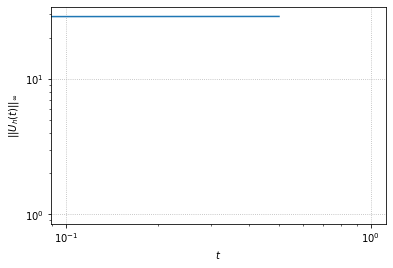

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.25 



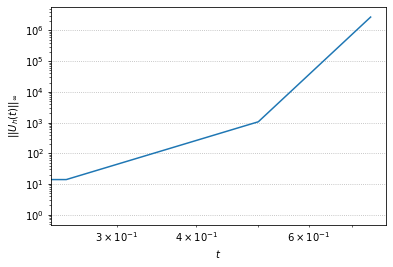

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.125 



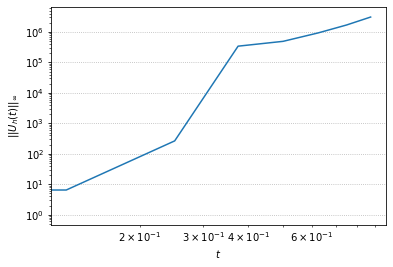

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.0625 



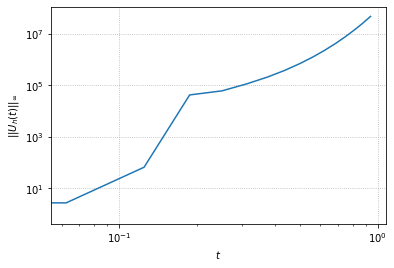

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.03125 



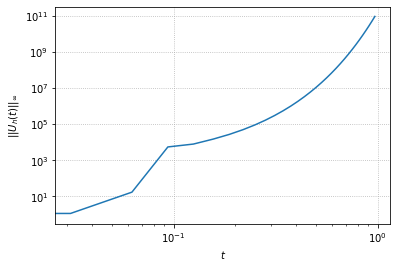

# ---------------------------------------------------------------- # 

Method:
BDF 

h   = 0.015625 

tau = 0.015625 



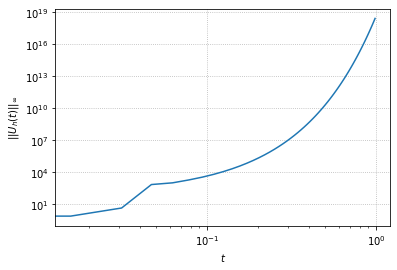

# ---------------------------------------------------------------- # 



In [12]:
p_min = 1
# p_max = 10
p_max = 6

h_array   = [2**(-p) for p in range(p_min, p_max+1)]
tau_array = [2**(-p) for p in range(p_min, p_max+1)]

t_0 = 0
T   = 1

def Rest(t, y):

    y_maximums = np.array([max(abs(y_)) for y_ in y.transpose()])

    fig = plt.plot()

    plt.loglog(t, y_maximums)
    plt.xlabel("$t$")
    plt.ylabel("$|| U_h(t) ||_\infty$")
    plt.grid(linestyle = ':')
    plt.show()

    print('#', '-'*64, '#', '\n')

print('#', '-'*64, '#', '\n')

for h in h_array:

    for tau in tau_array:

        M_ = M(h)
#         print('M(h) =')
#         print(M_)
#         print('')

        # right hand side
#         f = lambda t_, y_: M(h) @ y_
        def f(t, y):

#             print('M(h) =')
#             print(M_)
#             print('y =')
#             print(y)
#             print('')

            return M_ @ y

        N = int(1/h)

        # initial value
        Delta = np.array([i/N for i in range(1, N)])
        y_0 = G = g(Delta)

        # time frames
        t = np.arange(t_0, T, tau)

#         # ---------------- #

#         print('Method:')
#         print('adams bashforth with k = 2', '\n')

#         print("h   =", h,   '\n')
#         print("tau =", tau, '\n')

#         butcher_tableau = RK4()
#         y_init = explicit_RK(f, y_0, t[:2], butcher_tableau)
# #         print('y_init =')
# #         print(y_init)
# #         print('')

#         alpha, beta = adams_bashforth(2)
#         y = explicit_multistep_ODE_solver(alpha, beta, tau, f, y_init, t_0, T)
# #         print(y)
#         Rest(t, y)

#         # ---------------- #

#         print('Method:')
#         print('adams moulton with k = 2', '\n')

#         print("h   =", h,   '\n')
#         print("tau =", tau, '\n')

#         butcher_tableau = RK4()
#         y_init = explicit_RK(f, y_0, t[:2], butcher_tableau)
# #         print('y_init =')
# #         print(y_init)
# #         print('')

#         alpha, beta = adams_moulton(2)
#         y = implicit_multistep_ODE_solver_special(alpha, beta, tau, M_, y_init, t_0, T)
#         Rest(t, y)

#         # ---------------- #

#         print('Method:')
#         print('adams moulton with k = 3', '\n')

#         print("h   =", h,   '\n')
#         print("tau =", tau, '\n')

#         butcher_tableau = RK4()
#         y_init = explicit_RK(f, y_0, t[:3], butcher_tableau)
# #         print('y_init =')
# #         print(y_init)
# #         print('')

#         alpha, beta = adams_moulton(3)
#         y = implicit_multistep_ODE_solver_special(alpha, beta, tau, M_, y_init, t_0, T)
# #         print(y)
# #         print('len(t) =', len(t))
# #         print('len(y) =', len(y))
# #         print('')
#         Rest(t, y)

#         # ---------------- #

        print('Method:')
        print('BDF', '\n')

        print("h   =", h,   '\n')
        print("tau =", tau, '\n')

        butcher_tableau = RK4()
        y_init = explicit_RK(f, y_0, t[:4], butcher_tableau)
#         print('y_init =')
#         print(y_init)
#         print('')

        alpha, beta = BDF()
        y = implicit_multistep_ODE_solver_special(alpha, beta, tau, M_, y_init, t_0, T)
        Rest(t, y)

In [ ]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])

x.shape